# Vessel Detection Cross-Validation Evaluation

This notebook provides a comprehensive visualization and analysis of vessel detection results
across 4 datasets with 5-fold cross-validation. The analysis includes:

1. Performance metrics summary
2. ROC curves and Precision-Recall curves
3. Confusion matrices
4. Cross-dataset performance comparison
5. Per-fold analysis and variance assessment
6. Statistical significance testing
7. Threshold optimization analysis

In [56]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = sns.color_palette("tab10")

# Configure plot defaults
FIGSIZE = (12, 8)
plt.rcParams['figure.figsize'] = FIGSIZE
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Define dataset names - update these to match your actual datasets
DATASETS = ["Original_1", "Augmented_2", "Mixed_3", "Synthetic_4"]
DATASET_SIZES = {"Original_1": 4000, "Augmented_2": 6000, "Mixed_3": 8000,"Synthetic_4": 10000}
N_FOLDS = 5  # 5-fold cross-validation

In [2]:
def load_all_results(base_path=r"E:\Datasets\masati-thesis\results"):
    """
    Load all results.csv files for each dataset and fold.
    Expected structure: <base_path>/<dataset>/results/fold_X/results.csv

    Returns a nested dictionary: results[dataset][fold] = dataframe
    """
    results = {}

    print("Searching for result files...")

    for dataset in DATASETS:
        results[dataset] = {}
        dataset_path = os.path.join(base_path, dataset, 'results')

        print(f"Dataset: {dataset}")

        # Search pattern for: fold_X/results.csv
        csv_paths = glob.glob(os.path.join(dataset_path, "fold_*", "results.csv"))
        print(dataset_path)

        for csv_path in csv_paths:
            # Extract fold number from folder name (fold_0)
            fold_folder = os.path.basename(os.path.dirname(csv_path))
            fold = int(fold_folder.replace("fold_", "")) + 1
            print(f"  - Loading fold {fold} from {csv_path}")
            results[dataset][fold] = pd.read_csv(csv_path)


    print("\nData loading complete.")
    return results

# Load the results (or create simulated data if no files found)
results = load_all_results()

Searching for result files...
Dataset: Original_1
E:\Datasets\masati-thesis\results\Original_1\results
  - Loading fold 1 from E:\Datasets\masati-thesis\results\Original_1\results\fold_0\results.csv
  - Loading fold 2 from E:\Datasets\masati-thesis\results\Original_1\results\fold_1\results.csv
  - Loading fold 3 from E:\Datasets\masati-thesis\results\Original_1\results\fold_2\results.csv
  - Loading fold 4 from E:\Datasets\masati-thesis\results\Original_1\results\fold_3\results.csv
  - Loading fold 5 from E:\Datasets\masati-thesis\results\Original_1\results\fold_4\results.csv
Dataset: Augmented_2
E:\Datasets\masati-thesis\results\Augmented_2\results
  - Loading fold 1 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_0\results.csv
  - Loading fold 2 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_1\results.csv
  - Loading fold 3 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_2\results.csv
  - Loading fold 4 from E:\Datasets\masati-thesis\r

In [3]:
# Helper functions for metrics calculation
def calculate_training_metrics(df):
    """
    Calculate summarized training/validation metrics from a YOLOv8 training log CSV.
    Uses the last epoch's values by default.
    """
    last_epoch = df.iloc[-1]

    metrics = {
        'Precision': last_epoch['metrics/precision(B)'],
        'Recall': last_epoch['metrics/recall(B)'],
        'mAP50': last_epoch['metrics/mAP50(B)'],
        'mAP50-95': last_epoch['metrics/mAP50-95(B)'],
        'Train Box Loss': last_epoch['train/box_loss'],
        'Train Cls Loss': last_epoch['train/cls_loss'],
        'Train DFL Loss': last_epoch['train/dfl_loss'],
        'Val Box Loss': last_epoch['val/box_loss'],
        'Val Cls Loss': last_epoch['val/cls_loss'],
        'Val DFL Loss': last_epoch['val/dfl_loss'],
    }

    return metrics


def metrics_for_all_datasets(results):
    """
    Calculate summarized training metrics (like mAP, precision) for all datasets and folds.
    Assumes each DataFrame is a YOLO training log.
    """
    all_metrics = []

    for dataset in results:
        for fold in results[dataset]:
            df = results[dataset][fold]
            metrics = calculate_training_metrics(df)
            metrics['Dataset'] = dataset
            metrics['Fold'] = fold
            all_metrics.append(metrics)

    return pd.DataFrame(all_metrics)

## Performance Metrics Summary

In [4]:
# Display summary of metrics aggregated by dataset
metrics_df = metrics_for_all_datasets(results)
metrics_summary = metrics_df.groupby('Dataset').mean().drop(['TP', 'TN', 'FP', 'FN', 'Fold'], axis=1, errors='ignore')
metrics_summary

,Precision,Recall,mAP50,mAP50-95,Train Box Loss,Train Cls Loss,Train DFL Loss,Val Box Loss,Val Cls Loss,Val DFL Loss
Dataset,,,,,,,,,,
Augmented_2,0.699894,0.625494,0.646122,0.243382,2.095086,1.171598,1.058052,2.025610,1.280194,0.970096
Mixed_3,0.698562,0.632414,0.645730,0.246258,2.072166,1.155124,1.049064,1.891420,1.258872,0.916632
Original_1,0.782706,0.622882,0.716860,0.310480,1.770200,1.057362,0.955086,0.977706,1.102584,0.513476
Synthetic_4,0.708340,0.605600,0.632266,0.233602,2.153468,1.268410,1.041366,1.176562,0.757208,0.574592


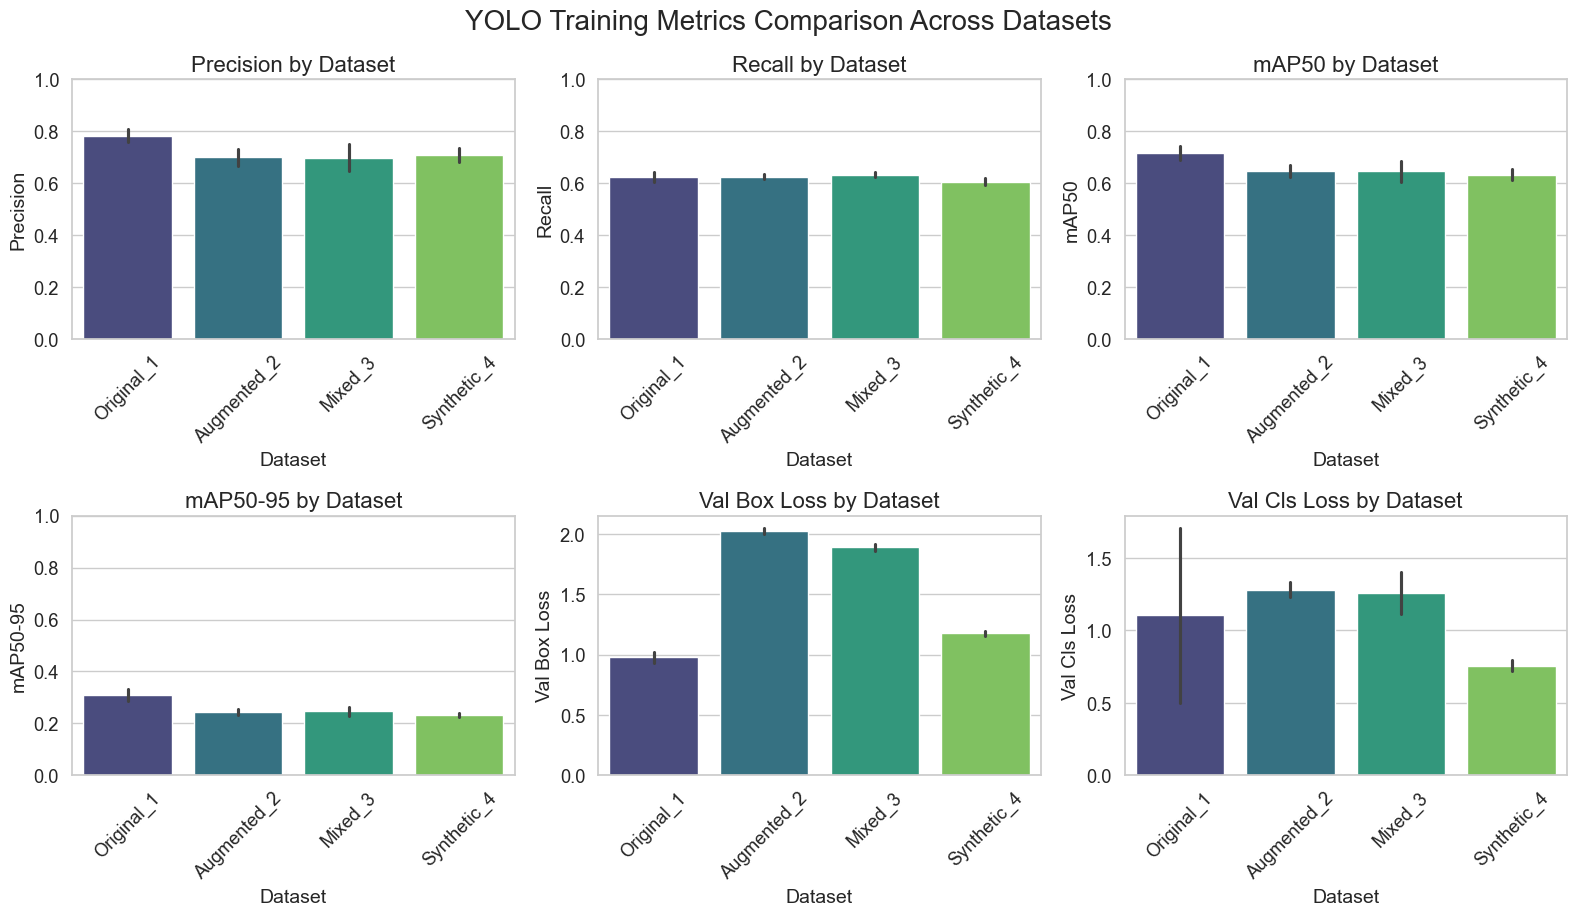

In [5]:
# Choose metrics to visualize
metrics_to_plot = ['Precision', 'Recall', 'mAP50', 'mAP50-95', 'Val Box Loss', 'Val Cls Loss']

# Convert 'Dataset' column to categorical for correct ordering
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

# Create plot
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x='Dataset', y=metric, data=metrics_df, palette='viridis', ci='sd')
    plt.title(f'{metric} by Dataset')
    if 'Loss' not in metric:
        plt.ylim(0.0, 1.0)  # For normalized metrics like precision/recall
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('YOLO Training Metrics Comparison Across Datasets', fontsize=20, y=1.02)
plt.show()

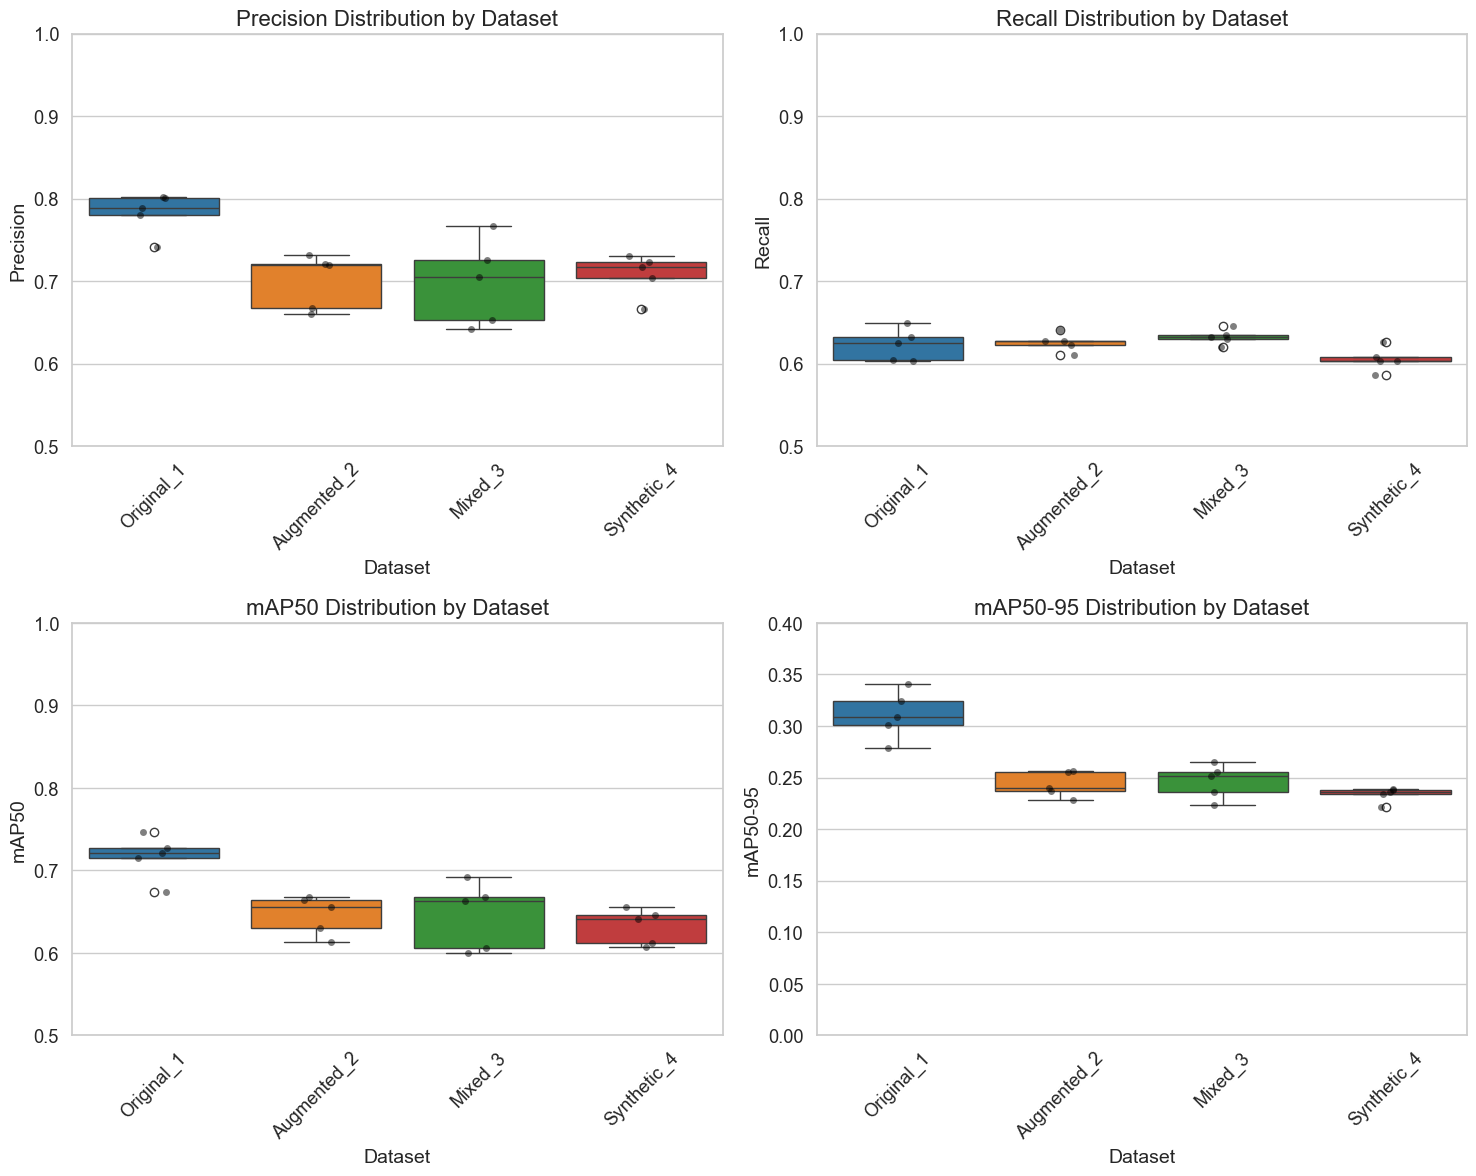

In [25]:
# Visualize fold variation within each dataset
plt.figure(figsize=(15, 12))

for i, metric in enumerate(metrics_to_plot[:4]):  # Plot first 4 metrics only
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Dataset', y=metric, data=metrics_df, palette='tab10')
    sns.stripplot(x='Dataset', y=metric, data=metrics_df, color='black', size=5, alpha=0.5)
    plt.title(f'{metric} Distribution by Dataset')
    plt.ylim(max(0.4, metrics_df[metric].min() - 0.05), min(1.0, metrics_df[metric].max() + 0.05))
    plt.xticks(rotation=45)

    # Set specific ylim for 'mAP50-95' to ensure data visibility
    if metric == 'mAP50-95':
        plt.ylim(0.0, 0.4)  # Adjusted range for mAP50-95
    else:
        plt.ylim(0.5, 1.0)  # Default range for other metrics

plt.tight_layout()
plt.show()

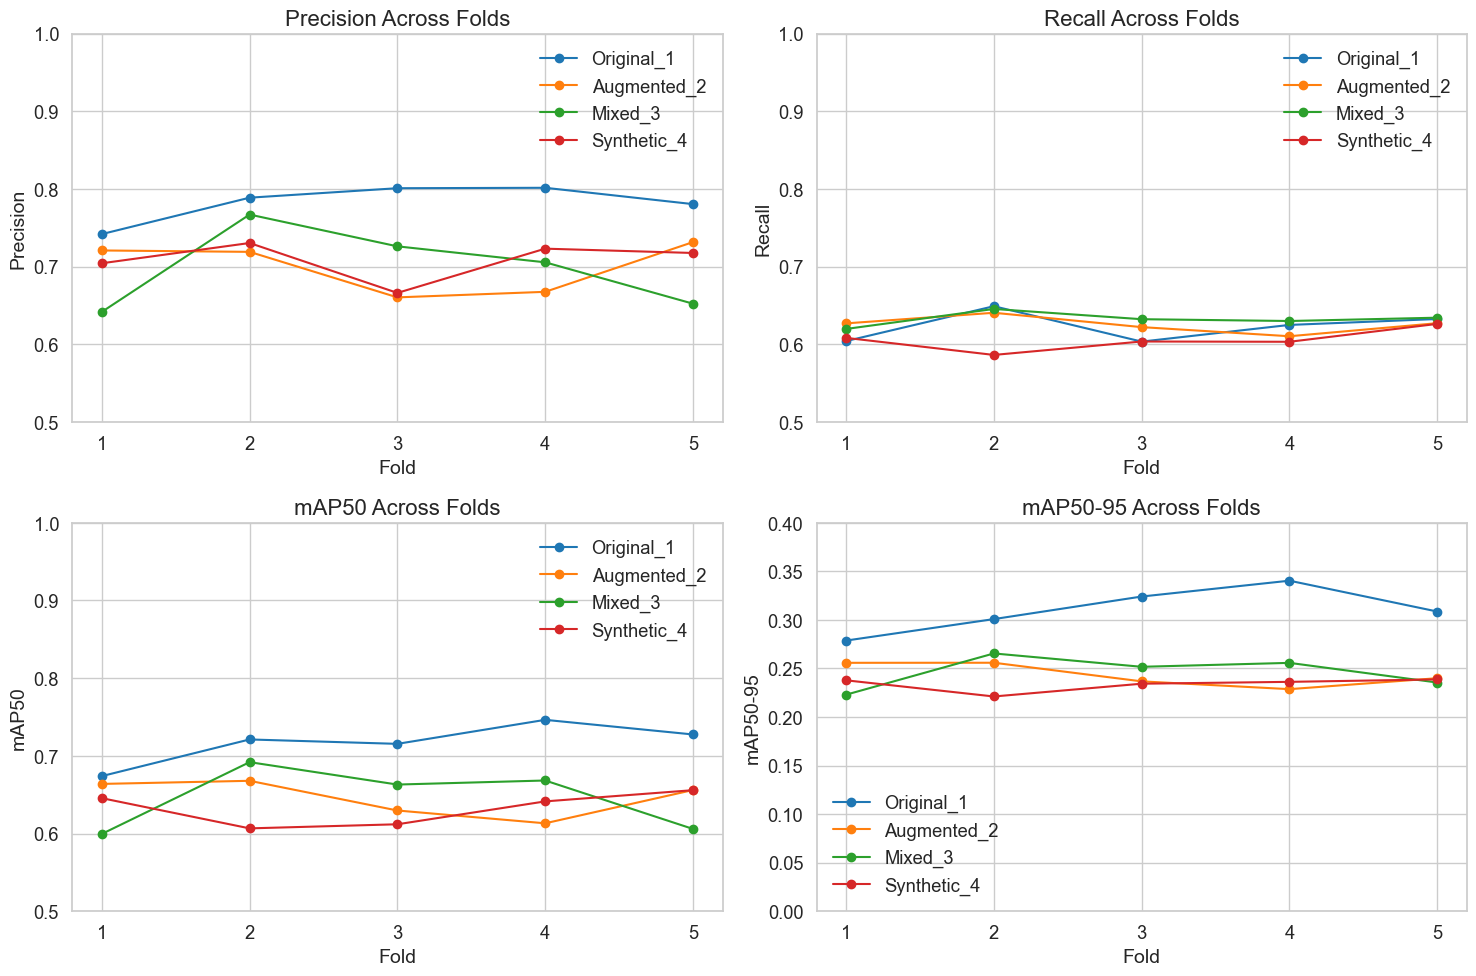

In [16]:
# Example color palette
colors = sns.color_palette('tab10', n_colors=len(DATASETS))

# Ensure 'Dataset' is treated as a categorical variable with the specified order
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

# Plot fold-wise performance trends
plt.figure(figsize=(15, 10))

for i, metric in enumerate(['Precision', 'Recall', 'mAP50', 'mAP50-95']):
    plt.subplot(2, 2, i + 1)
    for j, dataset in enumerate(DATASETS):
        dataset_metrics = metrics_df[metrics_df['Dataset'] == dataset]
        plt.plot(dataset_metrics['Fold'], dataset_metrics[metric], 'o-', label=dataset, color=colors[j])

    plt.title(f'{metric} Across Folds')
    plt.xlabel('Fold')
    plt.xticks(sorted(metrics_df['Fold'].unique()))  # Show only integer fold numbers
    plt.ylabel(metric)
    plt.grid(True, alpha=1)
    plt.legend()

    # Set specific ylim for 'mAP50-95' to ensure data visibility
    if metric == 'mAP50-95':
        plt.ylim(0.0, 0.4)  # Adjusted range for mAP50-95
    else:
        plt.ylim(0.5, 1.0)  # Default range for other metrics

plt.tight_layout()
#plt.suptitle('Fold-wise YOLO Performance Trends by Dataset', fontsize=18, fontweight="bold", y=1.02)
plt.show()

## Statistical Analysis of Performance Variance

In [8]:
# Calculate mean, std, and CV for YOLO metrics
stat_analysis = metrics_df.groupby('Dataset').agg({
    'Precision': ['mean', 'std', lambda x: x.std() / x.mean()],
    'Recall': ['mean', 'std', lambda x: x.std() / x.mean()],
    'mAP50': ['mean', 'std', lambda x: x.std() / x.mean()],
    'mAP50-95': ['mean', 'std', lambda x: x.std() / x.mean()]
})

# Rename columns: replace <lambda_0> with 'cv'
stat_analysis.columns = [
    f'{metric}_{stat}' if stat != '<lambda_0>' else f'{metric}_cv'
    for metric, stat in stat_analysis.columns
]

# Optional: reset index for easier use
stat_analysis = stat_analysis.reset_index()

# Display
stat_analysis


,Dataset,Precision_mean,Precision_std,Precision_cv,Recall_mean,Recall_std,Recall_cv,mAP50_mean,mAP50_std,mAP50_cv,mAP50-95_mean,mAP50-95_std,mAP50-95_cv
0,Original_1,0.782706,0.024456,0.031246,0.622882,0.019421,0.031180,0.716860,0.026671,0.037206,0.310480,0.023362,0.075244
1,Augmented_2,0.699894,0.033194,0.047427,0.625494,0.010867,0.017373,0.646122,0.023673,0.036639,0.243382,0.012069,0.049590
2,Mixed_3,0.698562,0.052103,0.074587,0.632414,0.009221,0.014581,0.645730,0.040796,0.063179,0.246258,0.016917,0.068697
3,Synthetic_4,0.708340,0.025416,0.035881,0.605600,0.014276,0.023573,0.632266,0.021698,0.034318,0.233602,0.007176,0.030718


### Variation Statistics

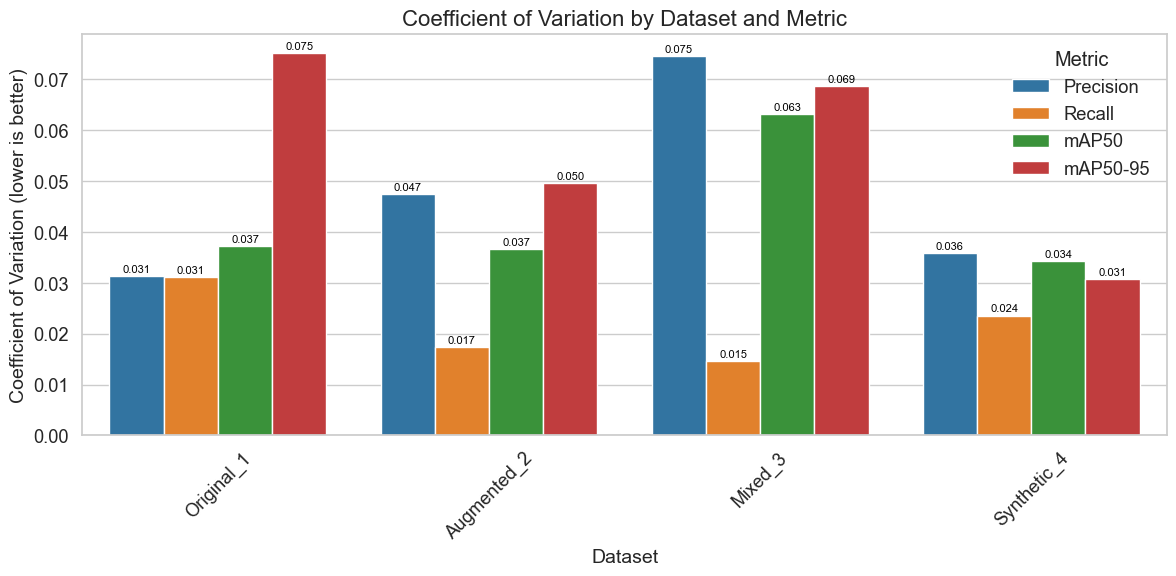

In [9]:
# Metrics that have CV stats
metrics_for_cv = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
# Prepare data for plotting
cv_data = pd.DataFrame({
    'Dataset': np.repeat(DATASETS, len(metrics_for_cv)),
    'Metric': np.tile(metrics_for_cv, len(DATASETS)),
    'CV': [stat_analysis.loc[stat_analysis['Dataset'] == dataset, f'{metric}_cv'].iloc[0] for dataset in DATASETS for
           metric in metrics_for_cv]
})

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Dataset', y='CV', hue='Metric', data=cv_data)

# === ✨ Add value labels to bars ===
for p in ax.patches:
    height = p.get_height()

    if height > 0.001:  # Avoid NaNs
        ax.annotate(f"{height:.3f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    fontsize=8, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')

# Labels and styling
plt.title('Coefficient of Variation by Dataset and Metric')
plt.ylabel('Coefficient of Variation (lower is better)')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Cross-Dataset Performance Ranking

<Figure size 1400x700 with 0 Axes>

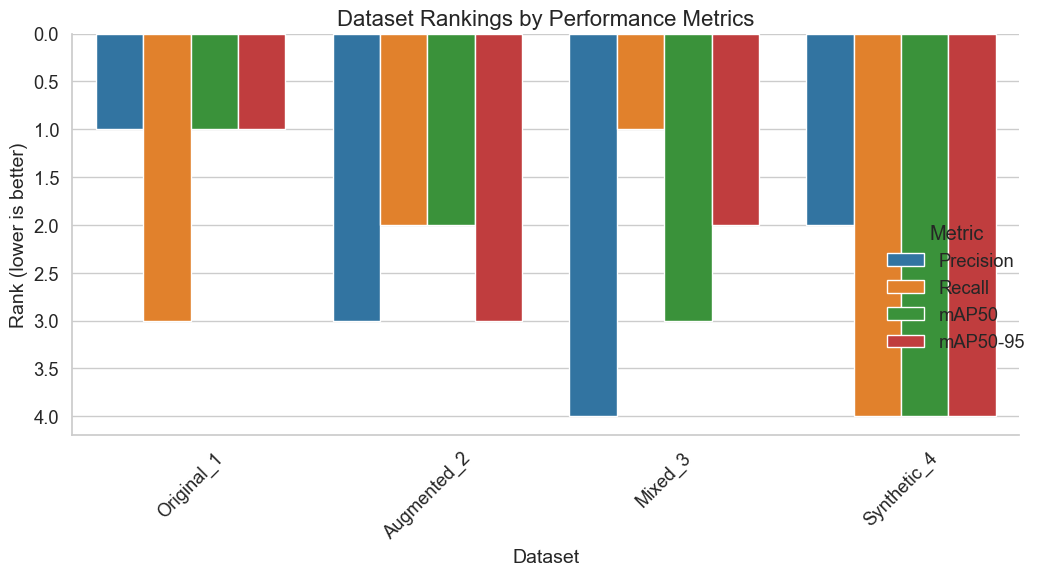

In [10]:
# Define the metrics you want to rank (adjust based on the actual column names)
rank_metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']

# If you want to add additional metrics like AUROC, AUPRC (if they exist in your dataset)
if 'AUROC' in metrics_df.columns:
    rank_metrics.extend(['AUROC', 'AUPRC'])

# Ensure 'Dataset' is treated as a categorical variable with the specified order
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

ranking_data = []

# Rank datasets by each metric
for metric in rank_metrics:
    # Get average metric per dataset (group by your dataset column, assuming you have one)
    avg_by_dataset = metrics_df.groupby('Dataset')[metric].mean().reset_index()
    # Sort and assign ranks (ascending=False for better ranks having lower values)
    avg_by_dataset['Rank'] = avg_by_dataset[metric].rank(ascending=False)
    avg_by_dataset['Metric'] = metric
    ranking_data.append(avg_by_dataset)

# Combine all metric rankings into one dataframe
ranking_df = pd.concat(ranking_data)

# Ensure 'Dataset' in ranking_df is also treated as categorical, to match the desired order in plots
ranking_df['Dataset'] = pd.Categorical(ranking_df['Dataset'], categories=DATASETS, ordered=True)

# Visualize dataset rankings
plt.figure(figsize=(14, 7))
g = sns.catplot(x='Dataset', y='Rank', hue='Metric', data=ranking_df, kind='bar', height=6, aspect=1.5, order=DATASETS)
plt.gca().invert_yaxis()  # Lower rank numbers are better
plt.title('Dataset Rankings by Performance Metrics')
plt.ylabel('Rank (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Overall ranking (average of all metric ranks)
overall_ranking = ranking_df.groupby('Dataset')['Rank'].mean().reset_index()
overall_ranking.columns = ['Dataset', 'Average_Rank']
overall_ranking = overall_ranking.sort_values('Average_Rank')
overall_ranking

,Dataset,Average_Rank
0,Original_1,1.5
1,Augmented_2,2.5
2,Mixed_3,2.5
3,Synthetic_4,3.5


## Performance Correlation Analysis

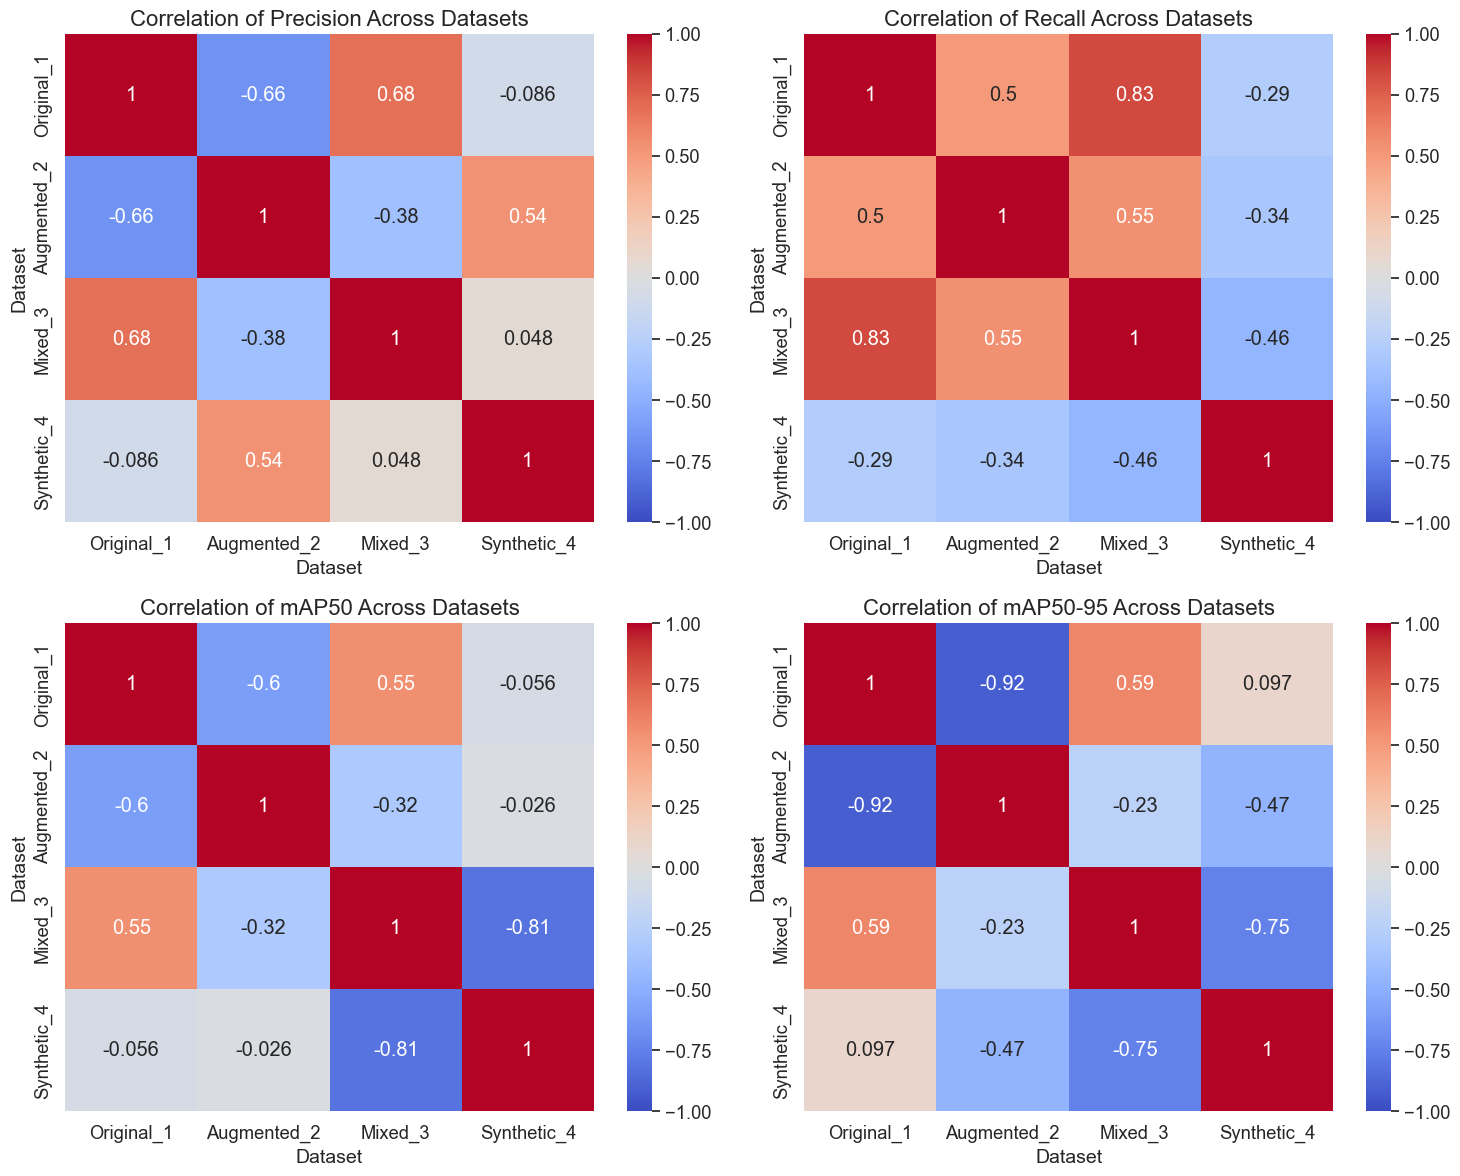

In [12]:
# List of metrics to plot
metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']

# Create the plot with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop over each metric to generate the heatmap
for i, metric in enumerate(metrics):
    # Create correlation matrix for the current metric
    corr_data = pd.pivot_table(
        metrics_df,
        values=metric,  # Use the current metric for correlation
        index='Fold',  # Group by fold
        columns='Dataset'
    )

    # Plot the heatmap for this metric
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Correlation of {metric.split("/")[-1]} Across Datasets')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

### Metric Correlation Analysis

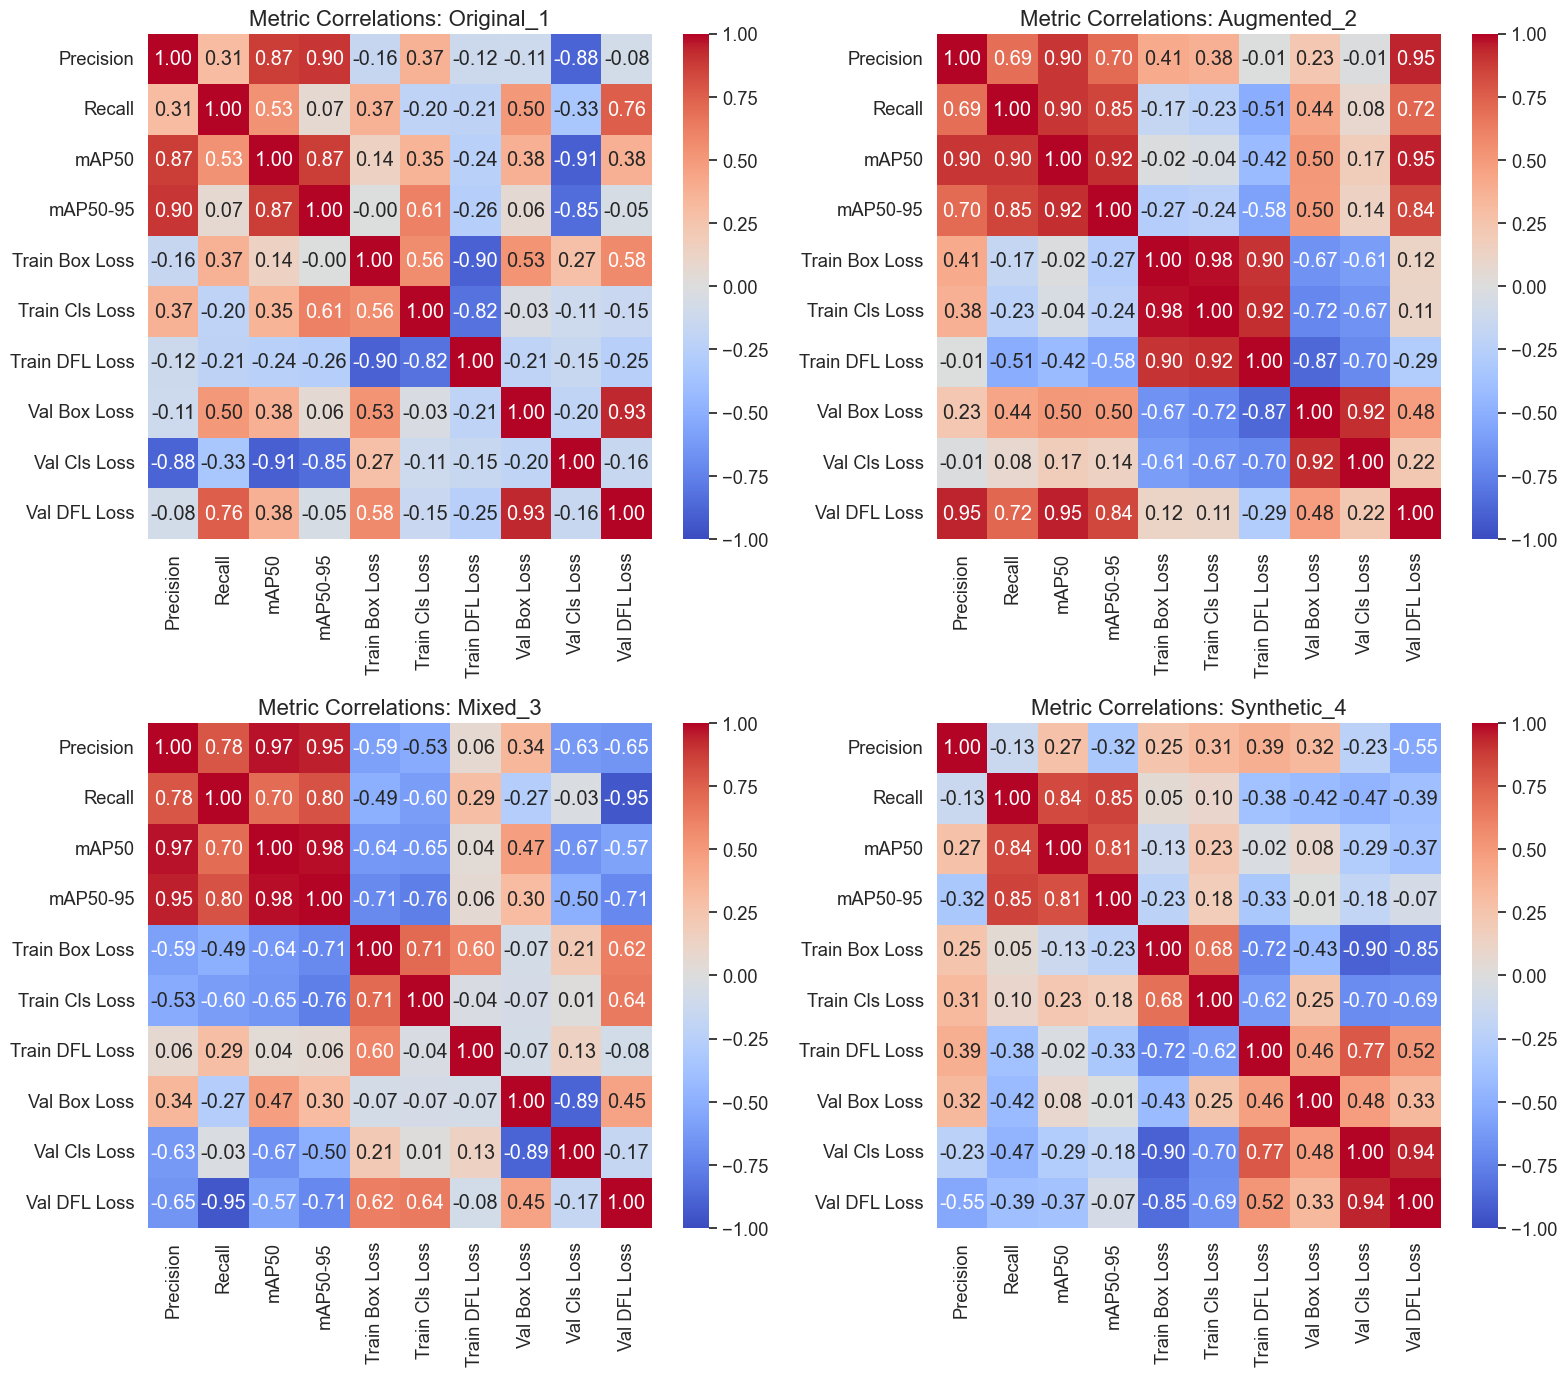

In [13]:
# Select numeric metrics for correlation
numeric_metrics = metrics_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_metrics = [m for m in numeric_metrics if m not in ['Fold', 'TP', 'TN', 'FP', 'FN']]

# Plot correlation heatmaps for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, dataset in enumerate(DATASETS):
    dataset_metrics = metrics_df[metrics_df['Dataset'] == dataset][numeric_metrics]
    sns.heatmap(dataset_metrics.corr(), annot=True, cmap='coolwarm',
                vmin=-1, vmax=1, ax=axes[i], fmt='.2f')
    axes[i].set_title(f'Metric Correlations: {dataset}')

plt.tight_layout()
plt.show()

In [55]:
metrics_df['Size'] = metrics_df['Dataset'].map(DATASET_SIZES)
metrics_df

,Precision,Recall,mAP50,mAP50-95,Train Box Loss,Train Cls Loss,Train DFL Loss,Val Box Loss,Val Cls Loss,Val DFL Loss,Dataset,Fold,Size
0,0.74189,0.60420,0.67393,0.27868,1.77443,1.05561,0.95376,0.97095,2.11252,0.50854,Original_1,1,4000
1,0.78875,0.64908,0.72109,0.30079,1.77538,1.05248,0.94999,0.96955,1.20551,0.52158,Original_1,2,4000
2,0.80094,0.60353,0.71543,0.32402,1.75498,1.05821,0.96398,0.90656,0.81475,0.48564,Original_1,3,4000
3,0.80148,0.62500,0.74634,0.34033,1.78274,1.08018,0.93966,1.01243,0.71380,0.52172,Original_1,4,4000
4,0.78047,0.63260,0.72751,0.30858,1.76347,1.04033,0.96804,1.02904,0.66634,0.52990,Original_1,5,4000
5,0.72083,0.62699,0.66387,0.25578,2.09116,1.16728,1.05639,2.04355,1.31082,0.97907,Augmented_2,1,6000
6,0.71903,0.64064,0.66788,0.25585,2.09410,1.16894,1.05711,2.02108,1.23897,0.97414,Augmented_2,2,6000
7,0.66045,0.62217,0.62966,0.23668,2.08293,1.14344,1.05536,2.04698,1.33961,0.96238,Augmented_2,3,6000
8,0.66759,0.61044,0.61319,0.22866,2.10187,1.18915,1.06154,1.98868,1.21841,0.95928,Augmented_2,4,6000
9,0.73157,0.62723,0.65601,0.23994,2.10537,1.18918,1.05986,2.02776,1.29316,0.97561,Augmented_2,5,6000


## Dataset Size Effect

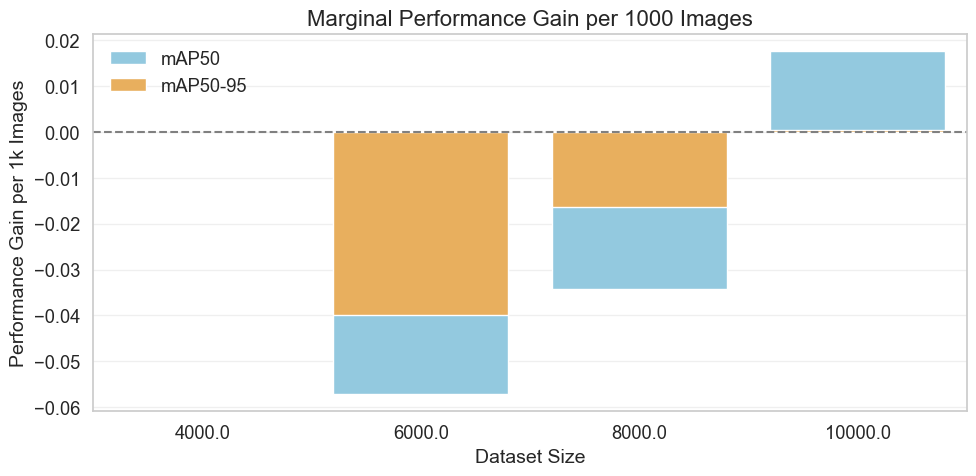

In [38]:
# Sort by dataset size to ensure correct order
df = metrics_df.sort_values(by='Size').reset_index(drop=True)

df['Size'] = df['Size'].astype(float)  # or int
df['Size_diff'] = df['Size'].diff()

# Calculate differences between each consecutive row
df['mAP50_gain_per_1k'] = df['mAP50'].diff() / (df['Size'].diff() / 1000)
df['mAP50-95_gain_per_1k'] = df['mAP50-95'].diff() / (df['Size'].diff() / 1000)


plt.figure(figsize=(10, 5))

# Plot for mAP50
sns.barplot(x=df['Size'][1:], y=df['mAP50_gain_per_1k'][1:], color='skyblue', label='mAP50')

# Plot for mAP50-95
sns.barplot(x=df['Size'][1:], y=df['mAP50-95_gain_per_1k'][1:], color='#FFB347', label='mAP50-95')

# Customize
plt.title('Marginal Performance Gain per 1000 Images')
plt.xlabel('Dataset Size')
plt.ylabel('Performance Gain per 1k Images')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

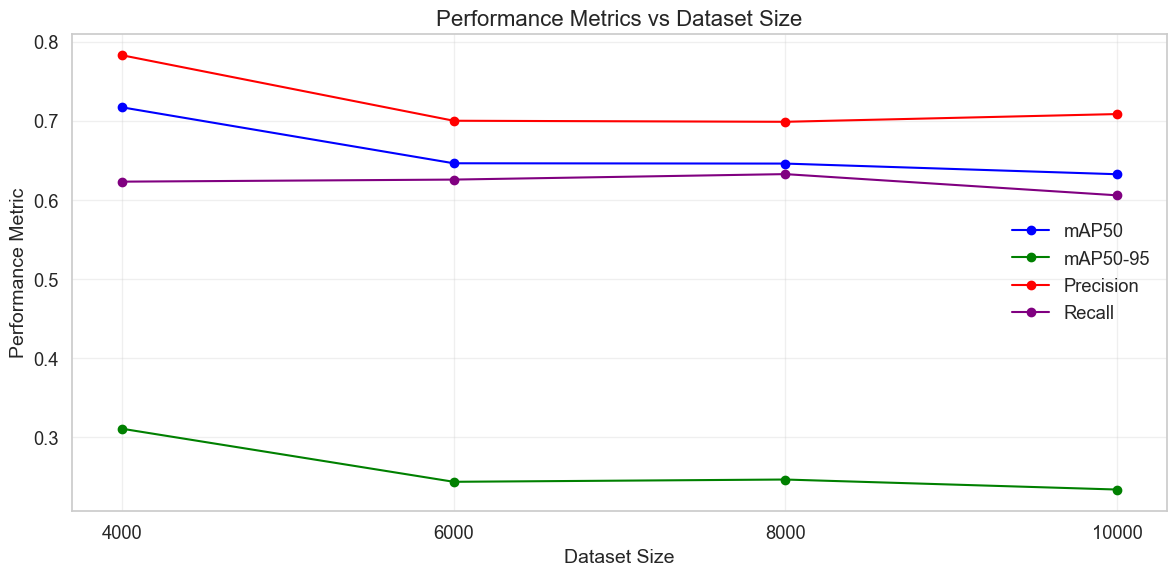

In [41]:
# Create a DataFrame for analyzing dataset size impact
size_impact_df = pd.DataFrame({
    'Dataset': DATASETS,
    'Size': [DATASET_SIZES[d] for d in DATASETS],
    'mAP50': [metrics_summary.loc[d, 'mAP50'] for d in DATASETS],
    'mAP50-95': [metrics_summary.loc[d, 'mAP50-95'] for d in DATASETS],
    'Precision': [metrics_summary.loc[d, 'Precision'] for d in DATASETS],
    'Recall': [metrics_summary.loc[d, 'Recall'] for d in DATASETS]
})

# Plot metrics vs dataset size
plt.figure(figsize=(12, 6))
metrics_to_plot = ['mAP50', 'mAP50-95', 'Precision', 'Recall']
colors = ['blue', 'green', 'red', 'purple']

for i, metric in enumerate(metrics_to_plot):
    plt.plot(size_impact_df['Size'], size_impact_df[metric], 'o-', label=metric, color=colors[i])

plt.xlabel('Dataset Size')
plt.ylabel('Performance Metric')
plt.title('Performance Metrics vs Dataset Size')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(size_impact_df['Size'])
plt.tight_layout()
plt.show()

,Metric,Dataset_Pair,Size_Increase,Absolute_Gain,Gain_per_1000
0,mAP50,Original_1 → Augmented_2,2000,-0.070738,-0.035369
1,mAP50-95,Original_1 → Augmented_2,2000,-0.067098,-0.033549
2,Precision,Original_1 → Augmented_2,2000,-0.082812,-0.041406
3,Recall,Original_1 → Augmented_2,2000,0.002612,0.001306
4,mAP50,Augmented_2 → Mixed_3,2000,-0.000392,-0.000196
5,mAP50-95,Augmented_2 → Mixed_3,2000,0.002876,0.001438
6,Precision,Augmented_2 → Mixed_3,2000,-0.001332,-0.000666
7,Recall,Augmented_2 → Mixed_3,2000,0.006920,0.003460
8,mAP50,Mixed_3 → Synthetic_4,2000,-0.013464,-0.006732
9,mAP50-95,Mixed_3 → Synthetic_4,2000,-0.012656,-0.006328


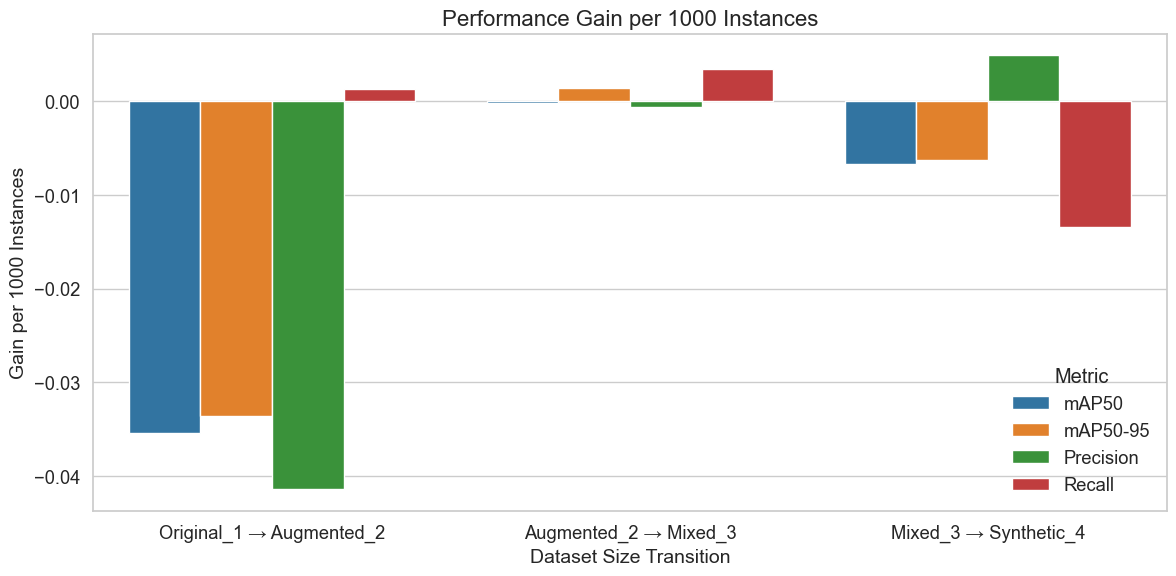

In [43]:
gain_df = pd.DataFrame(columns=['Metric', 'Dataset_Pair', 'Size_Increase', 'Absolute_Gain', 'Gain_per_1000'])

for i in range(len(DATASETS)-1):
    for metric in metrics_to_plot:
        dataset1 = DATASETS[i]
        dataset2 = DATASETS[i+1]
        size1 = DATASET_SIZES[dataset1]
        size2 = DATASET_SIZES[dataset2]
        size_diff = size2 - size1

        value1 = metrics_summary.loc[dataset1, metric]
        value2 = metrics_summary.loc[dataset2, metric]
        abs_gain = value2 - value1
        gain_per_1000 = abs_gain / (size_diff / 1000)

        new_row = {
            'Metric': metric,
            'Dataset_Pair': f"{dataset1} → {dataset2}",
            'Size_Increase': size_diff,
            'Absolute_Gain': abs_gain,
            'Gain_per_1000': gain_per_1000
        }

        gain_df = pd.concat([gain_df, pd.DataFrame([new_row])], ignore_index=True)

# Display the gain analysis
display(gain_df)

# Visualize gain per 1000 instances
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset_Pair', y='Gain_per_1000', hue='Metric', data=gain_df)
plt.title('Performance Gain per 1000 Instances')
plt.ylabel('Gain per 1000 Instances')
plt.xlabel('Dataset Size Transition')
plt.tight_layout()
plt.show()

## Convergence Analysis

In [78]:
def compute_normalized_gains(results, dataset_sizes):
    summary = []
    for dataset, folds in results.items():
        size = dataset_sizes[dataset]
        gains = []
        for df in folds.values():
            df_sorted = df.sort_values("epoch")
            map50 = df_sorted["metrics/mAP50(B)"].values
            gain = map50[-1] - map50[0]
            gain_per_epoch = gain / len(map50)
            gains.append(gain_per_epoch)
        avg_gain = sum(gains) / len(gains)
        normalized = avg_gain / (size / 1000)
        summary.append({
            "Dataset": dataset,
            "Size": size,
            "AvgGainPerEpoch": avg_gain,
            "NormalizedGain": normalized
        })
    return pd.DataFrame(summary).sort_values("Size")

gains_df = compute_normalized_gains(results, DATASET_SIZES)

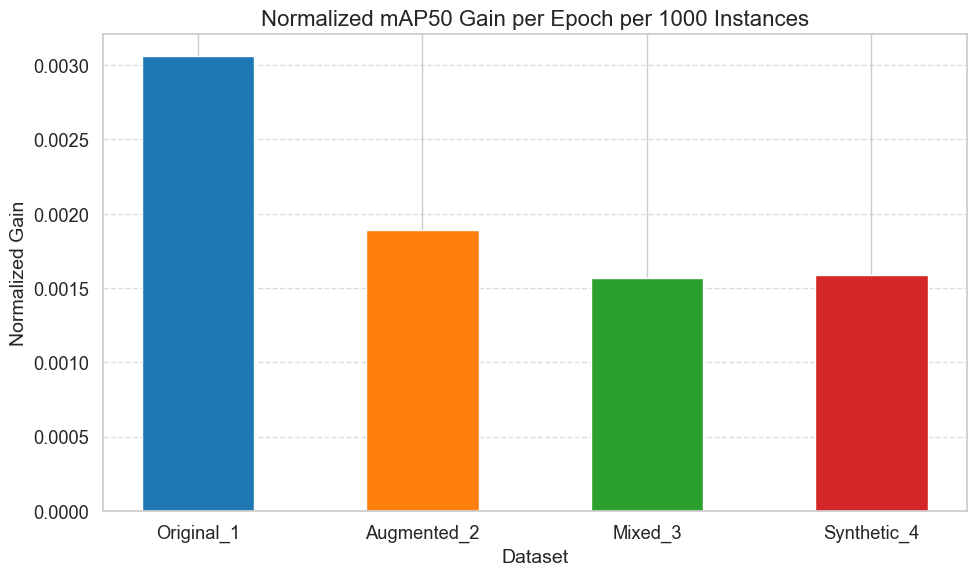

In [81]:
# Example data structure — replace with your actual values
dataset_names = ["Original_1", "Augmented_2", "Mixed_3", "Synthetic_4"]
dataset_sizes = [4000, 6000, 8000, 10000]
normalized_gain = gains_df["NormalizedGain"] # Replace with actual computed values

plt.figure(figsize=(10, 6))
plt.bar(dataset_names, normalized_gain, color=colors, width=0.5)
plt.title("Normalized mAP50 Gain per Epoch per 1000 Instances")
plt.xlabel("Dataset")
plt.ylabel("Normalized Gain")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
def get_avg_maps_by_epoch(results):
    dataset_maps = {}

    for dataset, folds in results.items():
        fold_map50 = []
        fold_map95 = []

        for fold_df in folds.values():
            df_sorted = fold_df.sort_values("epoch").reset_index(drop=True)
            mAP50 = df_sorted["metrics/mAP50(B)"]
            mAP95 = df_sorted["metrics/mAP50-95(B)"]

            fold_map50.append(mAP50)
            fold_map95.append(mAP95)

        # Align lengths (e.g., for early-stopped folds)
        max_len = min(len(f) for f in fold_map50)
        map50_avg = pd.concat([f[:max_len] for f in fold_map50], axis=1).mean(axis=1).tolist()
        map95_avg = pd.concat([f[:max_len] for f in fold_map95], axis=1).mean(axis=1).tolist()

        dataset_maps[dataset] = {
            "mAP50": map50_avg,
            "mAP50-95": map95_avg
        }

    return dataset_maps

avg_maps = get_avg_maps_by_epoch(results)

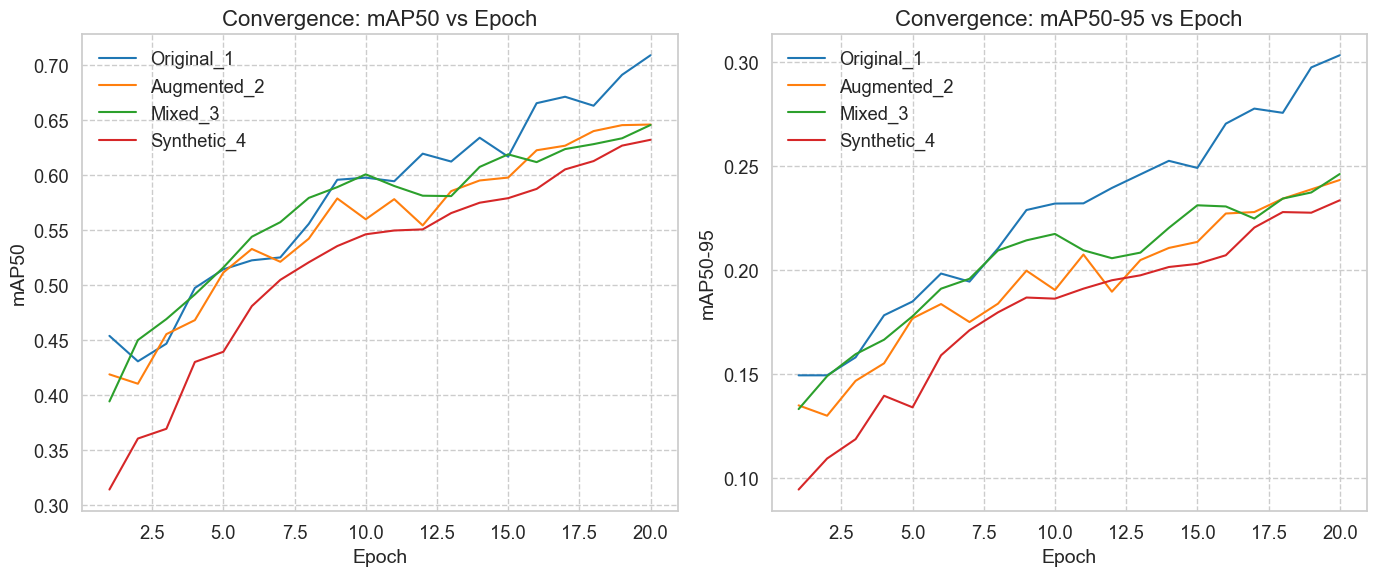

In [75]:
epochs = list(range(1, 21))
plt.figure(figsize=(14, 6))

# Plot mAP50
plt.subplot(1, 2, 1)
for ds in DATASETS:
    plt.plot(epochs, avg_maps[ds]["mAP50"], label=ds)
plt.title("Convergence: mAP50 vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("mAP50")
plt.grid(True, linestyle='--')
plt.legend()

# Plot mAP50-95
plt.subplot(1, 2, 2)
for ds in DATASETS:
    plt.plot(epochs, avg_maps[ds]["mAP50-95"], label=ds)
plt.title("Convergence: mAP50-95 vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.grid(True, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
def get_avg_losses_by_epoch(results):
    dataset_losses = {}

    for dataset, folds in results.items():
        box_losses = []
        cls_losses = []
        dfl_losses = []

        for fold_df in folds.values():
            df_sorted = fold_df.sort_values("epoch").reset_index(drop=True)

            box = df_sorted["train/box_loss"]
            cls = df_sorted["train/cls_loss"]
            dfl = df_sorted["train/dfl_loss"]

            box_losses.append(box)
            cls_losses.append(cls)
            dfl_losses.append(dfl)

        # Align epochs across folds
        max_len = min(len(f) for f in box_losses)
        box_avg = pd.concat([f[:max_len] for f in box_losses], axis=1).mean(axis=1).tolist()
        cls_avg = pd.concat([f[:max_len] for f in cls_losses], axis=1).mean(axis=1).tolist()
        dfl_avg = pd.concat([f[:max_len] for f in dfl_losses], axis=1).mean(axis=1).tolist()

        dataset_losses[dataset] = {
            "box": box_avg,
            "cls": cls_avg,
            "dfl": dfl_avg
        }

    return dataset_losses


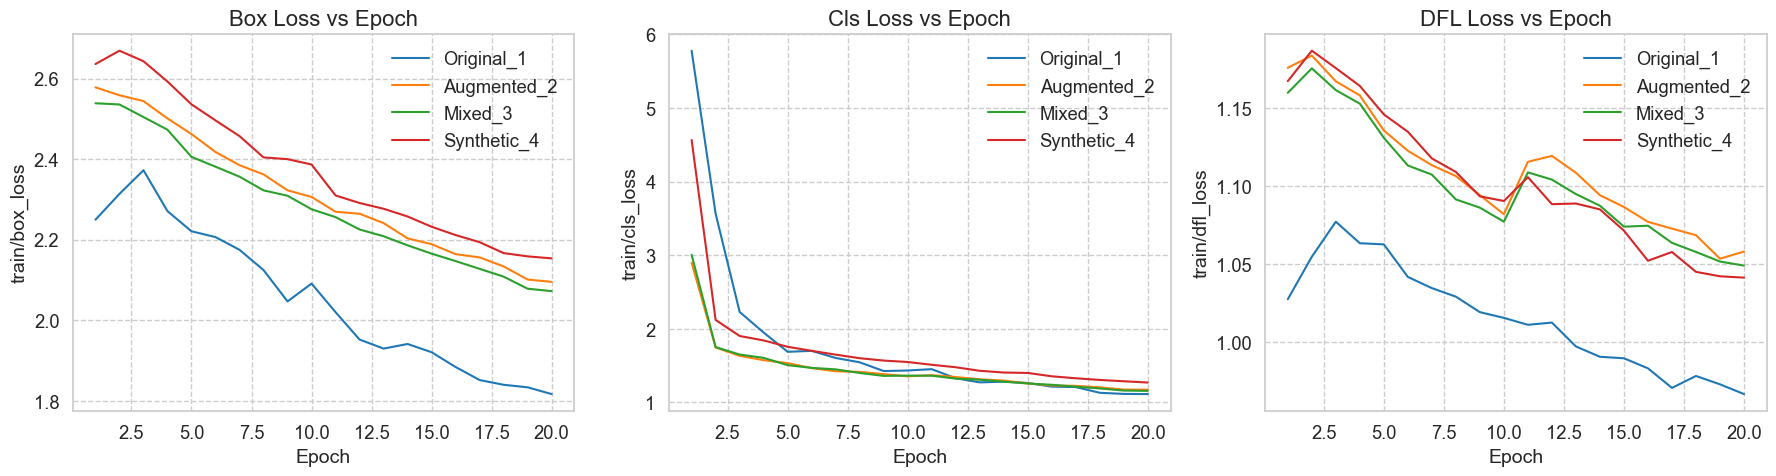

In [77]:
# Call the function
avg_losses = get_avg_losses_by_epoch(results)

# Dataset list and epochs
datasets = ["Original_1", "Augmented_2", "Mixed_3", "Synthetic_4"]
epochs = list(range(1, 21))

plt.figure(figsize=(18, 5))

# Box loss
plt.subplot(1, 3, 1)
for ds in datasets:
    plt.plot(epochs, avg_losses[ds]["box"], label=ds)
plt.title("Box Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("train/box_loss")
plt.grid(True, linestyle='--')
plt.legend()

# Cls loss
plt.subplot(1, 3, 2)
for ds in datasets:
    plt.plot(epochs, avg_losses[ds]["cls"], label=ds)
plt.title("Cls Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("train/cls_loss")
plt.grid(True, linestyle='--')
plt.legend()

# DFL loss
plt.subplot(1, 3, 3)
for ds in datasets:
    plt.plot(epochs, avg_losses[ds]["dfl"], label=ds)
plt.title("DFL Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("train/dfl_loss")
plt.grid(True, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()
